## Plot DM structure for different halos.

In [1]:
from shared.preface import *
import shared.functions as fct


PRE = PRE(
    sim='L012N376', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=1, sim_CPUs=6
)

# Make temporary folder to store files, s.t. parallel runs don't clash.
rand_code = ''.join(
    random.choices(string.ascii_uppercase + string.digits, k=4)
)
TEMP_DIR = f'{PRE.OUT_DIR}/temp_data_{rand_code}'
os.makedirs(TEMP_DIR)

Testing=False
if Testing:
    mass_gauge = 12.3
    mass_range = 0.3
    size = 1
else:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 10

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, TEMP_DIR
)
halo_batch_IDs = np.load(f'{TEMP_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{TEMP_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')


for halo_j, halo_ID in enumerate(halo_batch_IDs[:1]):

    # Manually adjust DM inclusion radius and number of halos.
    # (for manual job submissions on snellius)
    Rvir_halo = halo_batch_params[halo_j,0]
    Rvir_multiplier = 4  # 2,4,8,16 x Rvir
    DM_range_kpc = Rvir_multiplier*Rvir_halo*kpc  
    halos_inRange_lim = 2

    # '''
    # =============================================== #
    # Run precalculations for selected halo in batch. #
    # =============================================== #

    # Generate progenitor index array for current halo.
    splits = re.split('/', SIM_TYPE)
    MTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'
    proj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)


    # for j, (snap, proj_ID) in enumerate(zip(
    #     PRE.NUMS_SNAPS[::-1], proj_IDs
    # )):

    # For snapshot 0036 at z=0.
    snap, proj_ID = PRE.NUMS_SNAPS[-1], proj_IDs[0]
    proj_ID = int(proj_ID)

    print(f'halo {halo_j+1}/{halo_num} ; snapshot {snap}')
    

    # --------------------------- #
    # Read and load DM positions. #
    # --------------------------- #

    IDname = f'origID{halo_ID}_snap_{snap}'
    fct.read_DM_halos_inRange(
        snap, proj_ID, DM_range_kpc, int(halos_inRange_lim), 
        IDname, PRE.SIM_DIR, TEMP_DIR, PRE.PRE_CPUs
    )
    DM_raw = np.load(f'{TEMP_DIR}/DM_pos_{IDname}.npy')


# Remove temporary folder with all individual neutrino files.
shutil.rmtree(TEMP_DIR)

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: L012N376
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 1/6
DM limit for cells: 1000
# File management:
Box files directory: 
 /home/fabian/ownCloud/snellius/L012N376/DMONLY/SigmaConstant00
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/L012N376/DMONLY/SigmaConstant00
**********************************************************
16
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[195.00028262  11.89848321  13.2646342 ]
 [171.6865726   11.73258648   5.56997953]
 [139.87064301  11.46555721   7.37974116]
 [151.26621853  11.56760334   7.82480041]
 [298.72978142  12.45421305  10.25293176]
 [140.09726066  11.46766642  10.07694324]
 [153.19481535  11.58410969  10.62058499]
 [176.89228757  11.77150419   6.78838463]
 [173.01242844  11.7426094    5.41372435

550449


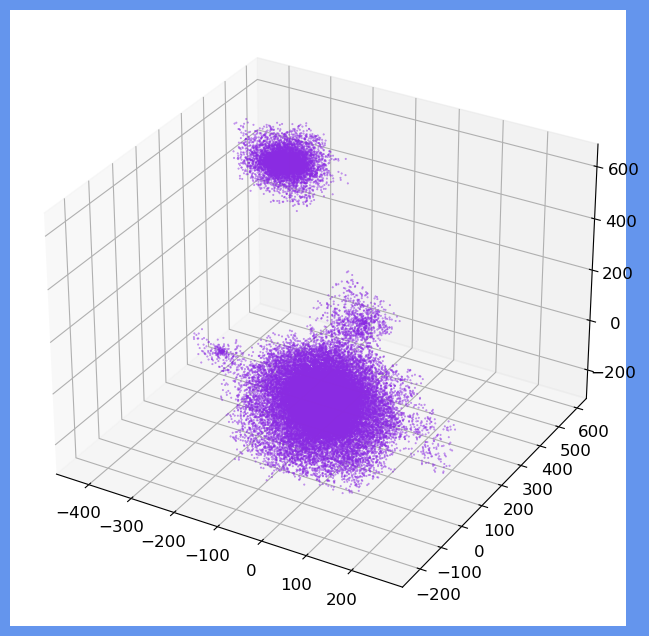

In [2]:
fig = plt.figure()
fig.patch.set_facecolor('cornflowerblue')
ax = fig.add_subplot(111, projection='3d')
# ax.patch.set_facecolor('cornflowerblue')
bubble_cmap = cc.cm.CET_D7  # blue-to-yellow, medium dark middle

print(len(DM_raw))
x_DM, y_DM, z_DM = DM_raw[:,0], DM_raw[:,1], DM_raw[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=0.6, c='blueviolet', s=0.2, label='DM particles')
plt.show()

## Test adaptive DM_lim implementation.

(1079, 1, 3)


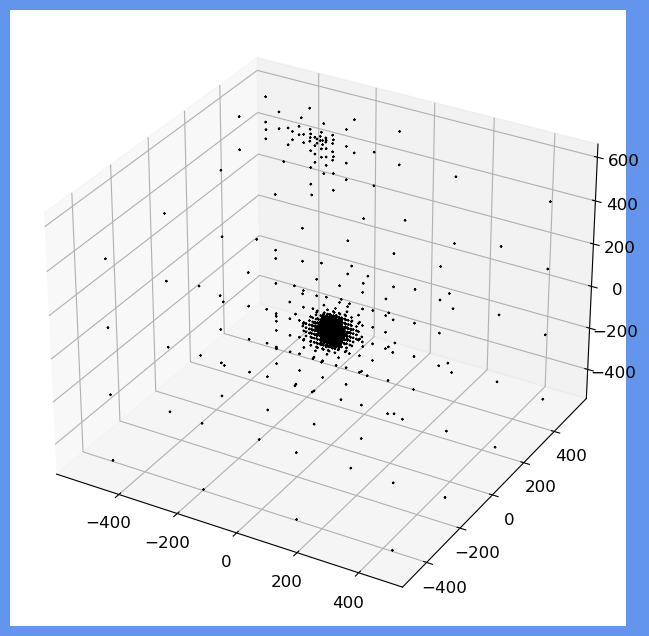

In [3]:
# ---------------------- #
# Cell division process. #
# ---------------------- #

# Make temporary folder to store files, s.t. parallel runs don't clash.
rand_code = ''.join(
    random.choices(string.ascii_uppercase + string.digits, k=4)
)
TEMP_DIR = f'{PRE.OUT_DIR}/temp_data_{rand_code}'
os.makedirs(TEMP_DIR)


# Initialize grid.
snap_GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
raw_grid = fct.grid_3D(snap_GRID_L, snap_GRID_L)
init_grid = np.expand_dims(raw_grid, axis=1)

# Prepare arrays for cell division.
DM_raw *= kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)

# Cell division.
cell_division_count = fct.cell_division(
    init_grid, DM_pos_for_cell_division, snap_GRID_L, PRE.DM_LIM, None, TEMP_DIR, IDname
)

# Load files from cell division.
fin_grid = np.load(f'{TEMP_DIR}/fin_grid_{IDname}.npy')
DM_count = np.load(f'{TEMP_DIR}/DM_count_{IDname}.npy')
cell_com = np.load(f'{TEMP_DIR}/cell_com_{IDname}.npy')
cell_gen = np.load(f'{TEMP_DIR}/cell_gen_{IDname}.npy')


# Remove temporary folder.
shutil.rmtree(TEMP_DIR)

print(fin_grid.shape)


# Plot grid over DM.
fig = plt.figure()
fig.patch.set_facecolor('cornflowerblue')
ax = fig.add_subplot(111, projection='3d')

plot_grid = np.squeeze(fin_grid, axis=1) / kpc
xg, yg, zg = plot_grid[:,0], plot_grid[:,1], plot_grid[:,2] 
ax.scatter(
    xg, yg, zg, s=1, marker='x', color='black', 
    alpha=1, label='Cell centers'
)
plt.show()